# Test Delight template fitting

- author : Sylvie Dagoret-Campagne

- affiliation : IJCLab/IN2P3/CNRS
- creation date : March 17th 2021
- update : April 3rd 2021
- update : May 13 th 2021 : implement the new prior calculation

must do 

        ln -s ../tmp
        ln -s ../tmpsim
   

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
sys.path.append('../')
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP

import seaborn as sns 

from rail.estimation.algos.include_delightPZ.libPriorPZ import *

Found classifier trainZ
Found classifier delightPZ
Found classifier simpleNN
Found classifier FZBoost
Found classifier randomPZ


In [2]:
from mpi4py import MPI
from delight.photoz_kernels import Photoz_mean_function, Photoz_kernel

In [3]:
logger = logging.getLogger(__name__)
coloredlogs.install(level='DEBUG', logger=logger,fmt='%(asctime)s,%(msecs)03d %(programname)s, %(name)s[%(process)d] %(levelname)s %(message)s')

In [4]:
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

# Configuration

- select if want to control Delight internal simulation or DC2

In [5]:
FLAG_DC2=False

In [6]:
if FLAG_DC2:
    configfilename='tmp/parametersTest.cfg'
else:
    configfilename='tmpsim/parametersTest.cfg'

In [7]:
FLAG_NEW_PRIOR = True

# Load config and data

In [8]:
comm = MPI.COMM_WORLD
threadNum = comm.Get_rank()
numThreads = comm.Get_size()

if threadNum == 0:
    logger.info("--- TEMPLATE FITTING ---")
    
    if FLAG_NEW_PRIOR:
        logger.info("==> New Prior calculation from Benitez")

2021-05-13 12:49:02,206 ipykernel_launcher.py, __main__[301] INFO --- TEMPLATE FITTING ---
2021-05-13 12:49:02,210 ipykernel_launcher.py, __main__[301] INFO ==> New Prior calculation from Benitez


In [9]:
# Parse parameters file

paramFileName = configfilename
params = parseParamFile(paramFileName, verbose=False)

if threadNum == 0:
    msg = 'Thread number / number of threads: ' + str(threadNum+1) + " , " + str(numThreads)
    logger.info(msg)
    msg = 'Input parameter file:' + paramFileName
    logger.info(msg)

2021-05-13 12:49:02,257 ipykernel_launcher.py, __main__[301] INFO Thread number / number of threads: 1 , 1
2021-05-13 12:49:02,261 ipykernel_launcher.py, __main__[301] INFO Input parameter file:tmp/parametersTest.cfg


In [11]:
#all_renormmodel=[]
#all_fluxes=[]
#all_z=[]
all_ell = []

In [12]:
# Create local files to store results
localPDFs = np.zeros((numLines, numZ))
localMetrics = np.zeros((numLines, numMetrics))




# Now loop over each target galaxy (indexed bu loc index) to compute likelihood function
# with its flux in each bands
loc = - 1
trainingDataIter = getDataFromFile(params, firstLine, lastLine,prefix="target_", getXY=False)
for z, normedRefFlux, bands, fluxes, fluxesVar,bCV, fCV, fvCV in trainingDataIter:
    loc += 1
    # like_grid, _ = scalefree_flux_likelihood(
    #    fluxes, fluxesVar,
    #    f_mod[:, :, bands])
    # ell_hat_z = normedRefFlux * 4 * np.pi\
    #    * params['fluxLuminosityNorm'] \
    #    * (DL(redshiftGrid)**2. * (1+redshiftGrid))[:, None]
    
    ell_hat_z = 1
    params['ellPriorSigma'] = 1e12

    # approximate flux likelihood, with scaling of both the mean and variance.
    # This approximates the true likelihood with an iterative scheme.
    # - data : fluxes, fluxesVar
    # - model based on SED : f_mod
    like_grid = approx_flux_likelihood(fluxes, fluxesVar, f_mod[:, :, bands],\
                                       normalized=True,\
                                       marginalizeEll=True,\
                                       ell_hat=ell_hat_z,\
                                       ell_var=(ell_hat_z*params['ellPriorSigma'])**2)
    
    ell = approx_flux_likelihood(fluxes, fluxesVar, f_mod[:, :, bands],\
                                       normalized=True,\
                                       marginalizeEll=True,\
                                       ell_hat=ell_hat_z,\
                                       ell_var=(ell_hat_z*params['ellPriorSigma'])**2,returnEllML=True)
    
    #all_z.append(z)
    if FLAG_DC2 and np.random.uniform()<0.2:
        all_ell.append(ell)
    elif not FLAG_DC2:
        all_ell.append(ell)
    #all_fluxes.append(fluxes)
   

    if FLAG_NEW_PRIOR:
        maglim=26  # M5 magnitude max
        p_z = libPriorPZ(redshiftGrid,maglim=maglim)  # return 2D template nz x nt, nt is 8


    else:
        b_in = np.array(params['p_t'])[None, :]
        beta2 = np.array(params['p_z_t'])**2.0

        #compute prior on z
        p_z = b_in * redshiftGrid[:, None] / beta2[None, :] *np.exp(-0.5 * redshiftGrid[:, None]**2 / beta2[None, :])

    if loc < 0:
        np.set_printoptions(threshold=20, edgeitems=10, linewidth=140,formatter=dict(float=lambda x: "%.3e" % x))  # float arrays %.3g
        print(p_z)


    #b_in = np.array(params['p_t'])[None, :]
    #beta2 = np.array(params['p_z_t'])**2.0

    #compute prior on z

    #p_z = b_in * redshiftGrid[:, None] / beta2[None, :] *np.exp(-0.5 * redshiftGrid[:, None]**2 / beta2[None, :])

    
    if loc < 0:
        np.set_printoptions(threshold=20, edgeitems=10, linewidth=140,formatter=dict(float=lambda x: "%.3e" % x))  # float arrays %.3g
        print(p_z)
    
    like_grid *= p_z

    localPDFs[loc, :] += like_grid.sum(axis=1)
    
    if localPDFs[loc, :].sum() > 0:
        localMetrics[loc, :] = computeMetrics(z, redshiftGrid,localPDFs[loc, :],params['confidenceLevels'])



Text(0.5, 1.0, 'Priors on redshift currently implemented for Delight ')

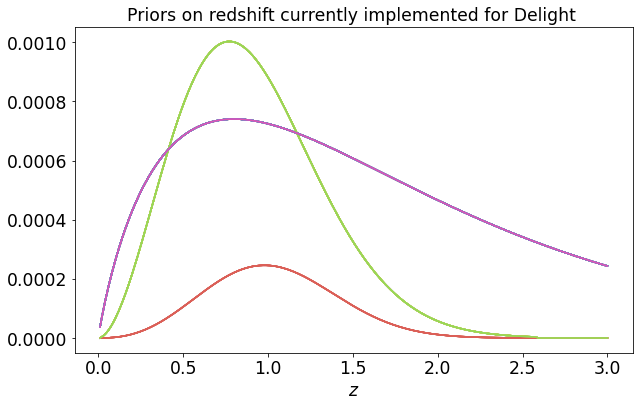

In [13]:
#sns.set_palette(sns.mpl_palette("winter"))
#sns.color_palette("hls", NGT)
NGT=p_z.shape[1]
mknames=["El_B2004a","Sbc_B2004a","Scd_B2004a","SB3_B2004a","SB2_B2004a","Im_B2004a","ssp_25Myr_z008","ssp_5Myr_z008"]
sns.set_palette("hls", NGT)
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
#colors = ['rosybrown', 'lightcoral', 'indianred', 'brown', 'firebrick', 'maroon','darkred', 'red', 'mystirose', 'salmon', 'tomato', 'darksalmon','coral', 'orangered', 'lightsalmon']
for idx in np.arange(NGT):
    ax.plot(redshiftGrid,p_z,label=mknames[idx])
#ax.legend()
ax.set_xlabel("$z$")
title="Priors on redshift currently implemented for Delight "
ax.set_title(title)

In [14]:
all_ell=np.array(all_ell)
#all_z=np.array(all_z)

In [15]:
all_ell.shape

(2136, 300, 8, 1)

In [16]:
#all_z.shape

In [17]:
redshiftGrid.size

300

In [18]:
Nt=len(sed_names)

In [19]:
NR=2  
NC=4   
NT=8
ND=all_ell.shape[0]

Text(0.5, 1.02, 'template fitting rescaling')

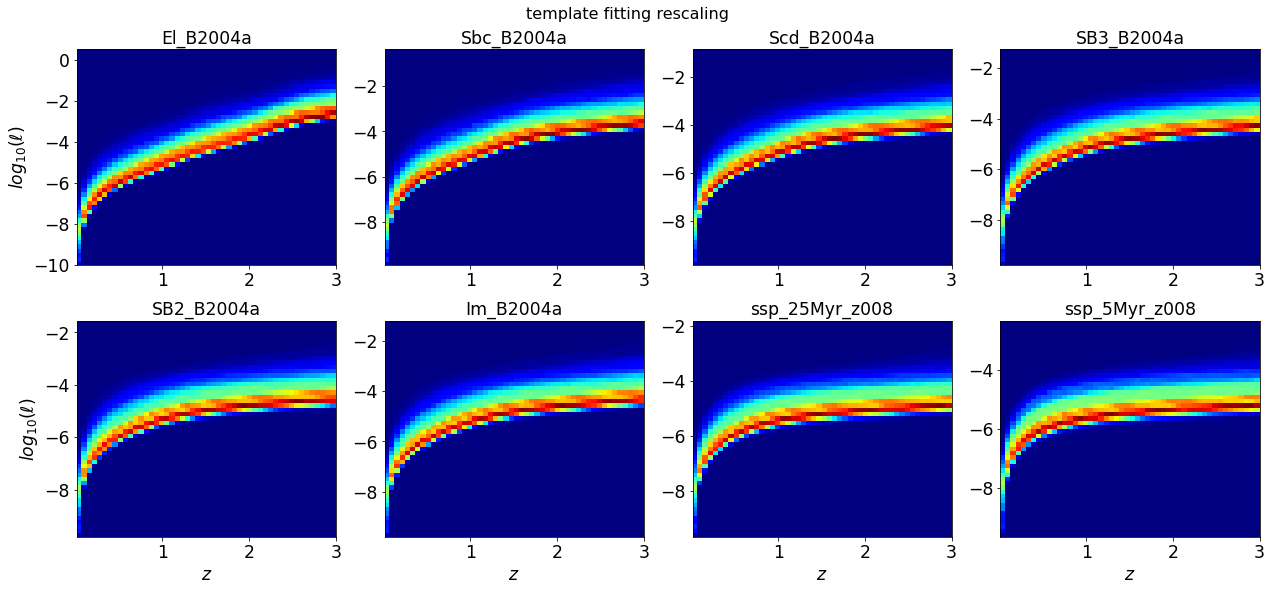

In [20]:
fig, axs = plt.subplots(NR, NC,figsize=(18,8))


for it in np.arange(len(sed_names)):
    
    z_coll=[]
    lell_coll=[]
    iy=it//NC
    ix=it-iy*NC

    for iz in np.arange(numZ):
        for idx in np.arange(ND):
            z_coll.append(redshiftGrid[iz])
            lell_coll.append(np.log10(all_ell[idx,iz,it,0]))
        
    axs[iy,ix].hist2d(z_coll,lell_coll,(50,50),cmap="jet");
    axs[iy,ix].set_title(sed_names[it])
    if iy==1:
        axs[iy,ix].set_xlabel("$z$")
    if ix==0:
        axs[iy,ix].set_ylabel("$log_{10}(\ell)$")
        
    
plt.tight_layout()
plt.suptitle("template fitting rescaling",y=1.02,fontsize=16)

In [21]:
#plt.hist(np.log10(np.array(all_ell)),bins=100);
#plt.xlabel("$log_{10}(\ell)$")
#plt.title("distribution of fitted $\ell$")

In [22]:
comm.Barrier()
if threadNum == 0:
    globalPDFs = np.zeros((numObjectsTarget, numZ))
    globalMetrics = np.zeros((numObjectsTarget, numMetrics))
else:
    globalPDFs = None
    globalMetrics = None

firstLines = [int(k*numObjectsTarget/numThreads) for k in range(numThreads)]
lastLines = [int(min(numObjectsTarget, (k+1)*numObjectsTarget/numThreads)) for k in range(numThreads)]
numLines = [lastLines[k] - firstLines[k] for k in range(numThreads)]

sendcounts = tuple([numLines[k] * numZ for k in range(numThreads)])
displacements = tuple([firstLines[k] * numZ for k in range(numThreads)])
comm.Gatherv(localPDFs,[globalPDFs, sendcounts, displacements, MPI.DOUBLE])

sendcounts = tuple([numLines[k] * numMetrics for k in range(numThreads)])
displacements = tuple([firstLines[k] * numMetrics for k in range(numThreads)])
comm.Gatherv(localMetrics,[globalMetrics, sendcounts, displacements, MPI.DOUBLE])

comm.Barrier()

if threadNum == 0:
    fmt = '%.2e'
    np.savetxt(params['redshiftpdfFileTemp'], globalPDFs, fmt=fmt)
    if redshiftColumn >= 0:
        np.savetxt(params['metricsFileTemp'], globalMetrics, fmt=fmt)